In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [4]:
grayImage = r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\albert-einstein_gray.jpg'
projectiveWarped = r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\projective_warped.jpg'


In [5]:
I_gray = cv2.imread(grayImage, cv2.IMREAD_GRAYSCALE)
I_projectiveWarp = cv2.imread(projectiveWarped, cv2.IMREAD_GRAYSCALE)

In [6]:
def f_getPoints(I, numPts):
    %matplotlib
    fig, ax = plt.subplots(1, figsize=(15,30))
    plt.imshow(I, cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts)))
    pts = pts[:, [1,0]].T
    plt.close()
    return pts

def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    fig_size = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

def bilinearInterpolation(r, c, I):
   
    # Column indexes
    lc = int(c) # left column
    rc = lc+1   # right column

    # Row indexes
    tr = int(r) # top row
    br = tr + 1 # bottom row

    # Weights of horizontal linear indexes
    wr = c - lc
    wl = rc - c

    # Weights of vertical linear indexes
    wt = br - r
    wb = r - tr

    if tr >= 0 and br < I.shape[0] and lc >= 0 and rc < I.shape[1]:  
        # Intensity alpha (top row linear)
        a = I[tr, lc] * wl + I[tr, rc] * wr
        # Intensity betha (bottom row linear)
        b = I[br, lc] * wl + I[br, rc] * wr

        # Final intensity (vertical linear)
        f = a * wt + b * wb

        return np.uint8(f)
    else:
        return 0
def getExtentsProjective(T, rMax, cMax):
    cords = np.array([[0,0,1], [0, cMax-1, 1], [rMax, 0, 1], [rMax, cMax, 1]])
    A_dash = T.dot(cords.T)
    A_dash = A_dash/A_dash[2,:]

    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)

    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))

    # Define height and width
    H, W = maxR - minR + 1, maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

def transformProjective(T, I_gray):
    Tinv = np.linalg.inv(T)

    numRows = I_gray.shape[0]
    numCols = I_gray.shape[1]

    minR, minC, maxR, maxC, H, W = getExtentsProjective(T, I_gray.shape[0], I_gray.shape[1])

    I2 = np.zeros((H,W), dtype='uint8')

    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i,new_j, 1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            # Bilinear interpolation
            P = np.int16(np.round(P))
            i, j = P[0], P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = bilinearInterpolation(i,j,I_gray)
                I2[new_i - minR, new_j - minC] = g
    return I2


In [6]:
P  = f_getPoints(I_gray, 3)
P

Using matplotlib backend: <object object at 0x00000134D921EC00>


array([[397., 403., 481., 566.],
       [322., 498., 435., 474.]])

In [7]:
P_dash  = f_getPoints(I_projectiveWarp, 4)
P_dash

Using matplotlib backend: TkAgg


array([[352., 342., 388.],
       [282., 372., 343.]])

In [9]:
P = np.vstack((P, np.ones((1, 3))))
P_dash = np.vstack((P_dash, np.ones((1,3))))

array([[352., 342., 388.],
       [282., 372., 343.],
       [  1.,   1.,   1.]])

In [10]:
H = P_dash.dot(np.linalg.inv(P))

In [11]:
I2 = transformProjective(H, I_gray)

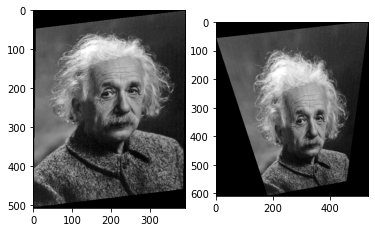

In [12]:
%matplotlib inline
plt.figure(1)
plt.subplot(121)
plt.imshow(I2, cmap='gray')
plt.subplot(122)
plt.imshow(I_projectiveWarp, cmap="gray")

In [13]:
H

array([[ 4.83372922e-01, -6.41330166e-02,  1.80396675e+02],
       [-6.53206651e-03,  5.26392188e-01,  1.14048694e+02],
       [ 0.00000000e+00, -2.98155597e-19,  1.00000000e+00]])

# Direct Linear Transform
Computing the null space

In [7]:
def computeRightNullSpace(A):
    B = A.T.dot(A)
    w, v = np.linalg.eig(B)
    idx = np.argmin(w)
    nullVector = v[:,idx]
    return nullVector

In [5]:
A = np.random.rand(3,4)

In [7]:
nv = computeRightNullSpace(A)

In [8]:
nv

array([-0.02510423, -0.83896969,  0.50955793,  0.18934189])

In [9]:
A.dot(nv)

array([ 0.00000000e+00,  4.99600361e-16, -1.24900090e-16])

## DLT Implementation
Marking correspondant points

In [8]:
P  = f_getPoints(I_gray, 6)
P

Using matplotlib backend: <object object at 0x0000018DFF2B2CA0>


array([[ -0.,  -0., 948., 946., 399., 401.],
       [ -0., 727., 727.,   0., 324., 499.]])

In [9]:
P_dash  = f_getPoints(I_projectiveWarp, 6)
P_dash

Using matplotlib backend: TkAgg


array([[ 59.,  -0., 556., 609., 354., 341.],
       [  1., 531., 455., 179., 280., 371.]])

Transforming to homogeneous coordinates

In [10]:
P = np.vstack((P, np.ones((1, 6))))
P_dash = np.vstack((P_dash, np.ones((1,6))))

In [11]:
A = np.zeros((12,9))

In [12]:
A[::2,:3] = -P.T
A[1::2,3:6] = -P.T
A[::2, 6:] = P.dot(np.diag(P_dash[0,:])).T
A[1::2, 6:] = P.dot(np.diag(P_dash[1,:])).T

In [13]:
A

array([[ 0.00000e+00,  0.00000e+00, -1.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         5.90000e+01],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00, -1.00000e+00,  0.00000e+00,  0.00000e+00,
         1.00000e+00],
       [ 0.00000e+00, -7.27000e+02, -1.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        -7.27000e+02, -1.00000e+00,  0.00000e+00,  3.86037e+05,
         5.31000e+02],
       [-9.48000e+02, -7.27000e+02, -1.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00,  5.27088e+05,  4.04212e+05,
         5.56000e+02],
       [ 0.00000e+00,  0.00000e+00,  0.00000e+00, -9.48000e+02,
        -7.27000e+02, -1.00000e+00,  4.31340e+05,  3.30785e+05,
         4.55000e+02],
       [-9.46000e+02, -0.00000e+00, -1.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000

In [14]:
h = computeRightNullSpace(A)

In [15]:
h

array([ 1.99424852e-02, -1.37501057e-03,  9.99531546e-01,  6.16556743e-03,
        1.32067862e-02,  6.57457440e-03,  1.67532355e-05,  1.82526985e-06,
        1.67760812e-02])

In [16]:
H = np.reshape(h, (3,3))

In [17]:
H

array([[ 1.99424852e-02, -1.37501057e-03,  9.99531546e-01],
       [ 6.16556743e-03,  1.32067862e-02,  6.57457440e-03],
       [ 1.67532355e-05,  1.82526985e-06,  1.67760812e-02]])

In [18]:
I2 = transformProjective(H, I_gray)

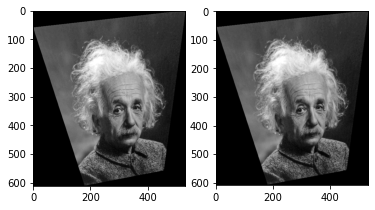

In [19]:
%matplotlib inline
plt.figure(1)
plt.subplot(121)
plt.imshow(I2, cmap='gray')
plt.subplot(122)
plt.imshow(I_projectiveWarp, cmap="gray")

# Panorama

In [20]:
im1 = cv2.imread(r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\1.jpg')
im2 = cv2.imread(r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\2.jpg')
im3 = cv2.imread(r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 5\3.jpg')

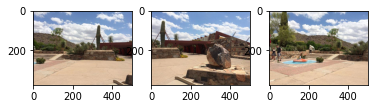

In [21]:
plt.subplot(131)
plt.imshow(im1[:,:,::-1])
plt.subplot(132)
plt.imshow(im2[:,:,::-1])
plt.subplot(133)
plt.imshow(im3[:,:,::-1])

In [22]:
imgs = []
imgs.append(im1)
imgs.append(im2)
imgs.append(im3)

In [23]:
M = cv2.Stitcher.create(cv2.Stitcher_PANORAMA)
status, pan = M.stitch(imgs)

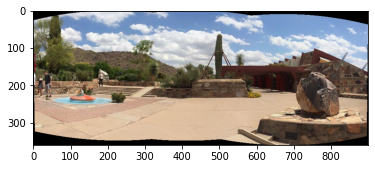

In [24]:
plt.imshow(pan[:,:,::-1])